In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Tokenizer, Word2Vec

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

In [2]:
# we use a set of constants for clarity and simplicity in managing the notebook.
# this allows you to refer back to this cell at any time if you need to either confirm or modify any of these values.

DATA_NAME = "Beauty_5.json"
APP_NAME = "Sentiment Analysis with Amazon Reviews Exercise"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

In [3]:
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sqlContext = SQLContext(sc)

In [4]:
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

In [5]:
beauty = sqlContext.read.json(DATA_NAME)

In [7]:
print(f"Dataset shape is {beauty.count():d} rows by {len(beauty.columns):d} columns.")

Dataset shape is 198502 rows by 9 columns.


In [8]:
beauty.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [9]:
beauty.registerTempTable('reviews')

In [10]:
sqlContext.sql("select overall, count(overall) as reviewCount from reviews group by overall order by overall desc").show()

+-------+-----------+
|overall|reviewCount|
+-------+-----------+
|    5.0|     114531|
|    4.0|      39741|
|    3.0|      22248|
|    2.0|      11456|
|    1.0|      10526|
+-------+-----------+



In [11]:
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else -1, IntegerType())

beauty = beauty.withColumn("overall_recode",udf(beauty.overall))

([<matplotlib.axis.XTick at 0x7febf94967f0>,
 <a list of 2 Text xticklabel objects>)

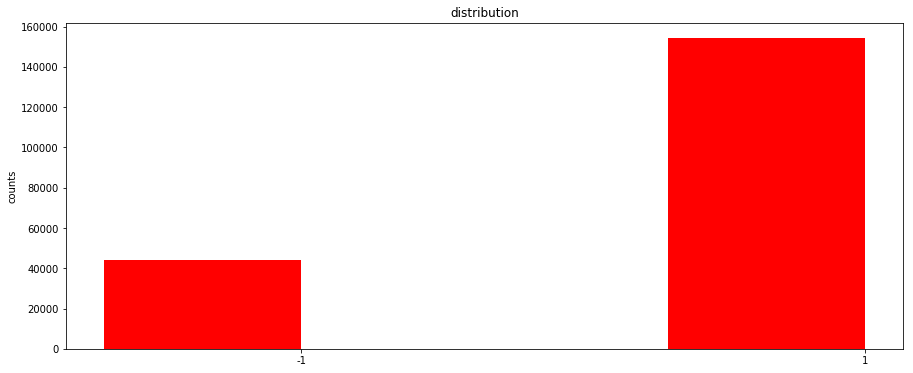

In [12]:
plt.rcParams['figure.figsize'] = (15, 6)
 
statuses = beauty.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind + width/2., categories)

In [13]:
beauty.select("overall", "overall_recode", "summary", "reviewText").show(10)

+-------+--------------+--------------------+--------------------+
|overall|overall_recode|             summary|          reviewText|
+-------+--------------+--------------------+--------------------+
|    1.0|            -1|Don't waste your ...|Very oily and cre...|
|    3.0|            -1|         OK Palette!|This palette was ...|
|    4.0|             1|       great quality|The texture of th...|
|    2.0|            -1|Do not work on my...|I really can't te...|
|    3.0|            -1|          It's okay.|It was a little s...|
|    5.0|             1|  Very nice palette!|I was very happy ...|
|    1.0|            -1|              smh!!!|PLEASE DONT DO IT...|
|    2.0|            -1|Chalky, Not Pigme...|Chalky,Not Pigmen...|
|    2.0|            -1|no Lightening, no...|Did nothing for m...|
|    3.0|            -1|         Its alright|I bought this pro...|
+-------+--------------+--------------------+--------------------+
only showing top 10 rows



In [15]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenized_text").transform(beauty)

word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol="tokenized_text", outputCol="w2v_vector").fit(tokenizer)

w2vdf=word2Vec.transform(tokenizer)

In [16]:
w2vdf.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- overall_recode: integer (nullable = true)
 |-- tokenized_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v_vector: vector (nullable = true)



In [17]:
w2vdf.select("overall_recode", "reviewText", "tokenized_text", "w2v_vector").show(10)

+--------------+--------------------+--------------------+--------------------+
|overall_recode|          reviewText|      tokenized_text|          w2v_vector|
+--------------+--------------------+--------------------+--------------------+
|            -1|Very oily and cre...|[very, oily, and,...|[-0.0226022373660...|
|            -1|This palette was ...|[this, palette, w...|[-0.0772195086573...|
|             1|The texture of th...|[the, texture, of...|[-0.0365141680733...|
|            -1|I really can't te...|[i, really, can't...|[-0.0428914880010...|
|            -1|It was a little s...|[it, was, a, litt...|[-0.0120184136841...|
|             1|I was very happy ...|[i, was, very, ha...|[-0.0313682227704...|
|            -1|PLEASE DONT DO IT...|[please, dont, do...|[0.00460213304965...|
|            -1|Chalky,Not Pigmen...|[chalky,not, pigm...|[-0.0265410064470...|
|            -1|Did nothing for m...|[did, nothing, fo...|[-0.0292037462760...|
|            -1|I bought this pro...|[i,

In [18]:
# Build the training indexers/split data/classifier
# first generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)
    
# Split the data into training and validation sets (20% held out for testing)
(trainingData, testData) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [19]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [20]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.220642
Accuracy = 0.779358
